# Data Scientist Professional Case Study

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


## Technical part :
My work is divided into six phases:
- Data analysis and preprocessing
- Exploratory Data Analysis
- Construction of an optimal dataset for a machine learning algorithm
- Construction and choice of model
- Optimization of the chosen model
- Analysis of predictive variables

The model presented meets the condition of success, namely, a margin of error of less than 50 percent, with an average of 46,6 percent and a standard deviation of 2,28 percent , validated on twenty folds.

## Key findings:

- The vast majority of views over the past seven days are from Switzerland , followed by Germany and Italy.
- The year of construction and the price are negatively correlated to the views (the lower the year and the price, the more views the boat will potentially have).
- The boat types with the highest view averages are "Wakeboard/Wakesurf" , "Classic, Runabout" and "Classic" types.
- The manufacturers with the highest view averages are "Tullio Abbate power boats" , "MasterCraft power boats" and "Draco power boats".
- The most useful variables for predicting the number of views are the manufacturer , location , and price.
- Even if there are quite few in our dataset, old boats arouse a lot of interest. Indeed , the three construction years with the highest view averages are 1980 , 1979 and 1973.
- People seem more interested by the small boats.

## Recommendations : 

This report suggests focusing on small, inexpensive boats and keep the marketing efforts on the most active geographical areas on the site, namely Switzerland, Germany, and Italy. It could also be profitable to give more visibility to old boats.

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Machine learning and statistics
import statistics
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.model_selection import cross_val_score , train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set the seed
np.random.seed(164)

## Data loading, analysis, preprocessing : 

After loading and inspecting the data, I made some changes to it. First, I got rid of rows containing missing values. Then I changed all the prices to euros. Finally I modified the 'Boat Type' and 'Location' columns to limit the number of categories, in order to make the dataset more digestible for the algorithm and help it find the right patterns.

In [2]:
# Load the data , inspect the first rows
df = pd.read_csv('boat_data.csv')
df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


In [3]:
# Check for null values
print(df.isna().sum())

# Check the number of unique values in the material column
print('Number of unique material : ' , len(df['Material'].unique()))

# Fill the null values in the material column with the most common ones , by manufacturer
to_map = dict(df.dropna().groupby('Manufacturer')['Material'].agg(statistics.mode))
df['Material'] = df['Material'].fillna(df['Manufacturer'].apply(lambda x : to_map.get(x)))
df['Material'] = df['Material'].fillna(df['Material'].agg(statistics.mode))

# Drop all the remaining missing values
df.dropna(inplace=True)
df = df[df['Year Built'] != 0]

# Create a copy of the dataframe before changing values
copy_ = df.copy()

# Get the uniques currency
print(df['Price'].apply(lambda x : x.split()[0]).unique())

# Create a dictionary with the values in euros
to_eur = {'CHF' : 1.02 , 'Â£' : 1.15 , 'DKK' : 0.13}

# Create a new list with the values preprocecced , in euros
clean_eur = []
for cur in df['Price']:
    if cur.split()[0] == 'EUR':
        clean_eur.append(float(cur.split()[1]))
    elif cur.split()[0] == 'CHF':
        clean_eur.append(float(cur.split()[1]) * to_eur['CHF'])
    elif cur.split()[0] == 'DKK':
        clean_eur.append(float(cur.split()[1]) * to_eur['DKK'])
    elif cur.split()[0] == 'Â£':
        clean_eur.append(float(cur.split()[1]) * to_eur['Â£'])

# Replace the old values by the new ones
df['Price'] = clean_eur

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64
Number of unique material :  12
['CHF' 'EUR' 'DKK' 'Â£']


In [4]:
# Gain some insights about the manufacturer 
best_manufacturer = df.groupby('Manufacturer')['Number of views last 7 days'].mean().to_frame().join(df['Manufacturer'].value_counts())
three_best_man = list(best_manufacturer[best_manufacturer['Manufacturer'] >= 10].nlargest(3 , columns='Number of views last 7 days').index)

# Display the results
print(f'The manufacturers with the highest view averages are "{three_best_man[0]}" , "{three_best_man[1]}" and "{three_best_man[2]}".')

# Gain some insights about the boat type
succesful_boat_type = df.groupby('Boat Type')['Number of views last 7 days'].mean().sort_values(ascending=False).to_frame().join(df['Boat Type'].value_counts().to_frame())

# Display the results
best_boat_types = list(succesful_boat_type[succesful_boat_type['Boat Type'] > 10][0 : 3].index)
print(f'The boat types with the highest view averages are "{best_boat_types[0]}" , "{best_boat_types[1]}" and "{best_boat_types[2]}" types.')

# Gain some insights about the year of construction
succesful_year_built = df.groupby('Year Built')['Number of views last 7 days'].mean().sort_values(ascending=False).to_frame().join(df['Year Built'].value_counts().to_frame())

# Display the results
best_year_built = list(succesful_year_built[succesful_year_built['Year Built'] > 10][0 : 3].index)
print(f'The three construction years with the highest view averages are {best_year_built[0]} , {best_year_built[1]} and {best_year_built[2]}.')

# Gain some insights about the width
quant_w = df['Width'].quantile([0.25 , 0.5 , 0.75]).values
cat_width = []
for width in df['Width']:
    if width <= quant_w[0]:
        cat_width.append('small')
    elif quant_w[0] < width <= quant_w[1]:
        cat_width.append('below average')
    elif quant_w[1] < width <= quant_w[2]:
        cat_width.append('above average')
    else:
        cat_width.append('big')

# Add it to the dataframe
df['Category_width'] = cat_width

# Display the result
best_width = list(df.groupby('Category_width')['Number of views last 7 days'].mean().nlargest(10).index)
print(f'The two widths categories that average the most views are "{best_width[0]}" and "{best_width[1]}".')
df.drop('Category_width' , axis=1 , inplace=True , errors='ignore')


# Gain some insights about the prices
quant_p = df['Price'].quantile([0.25 , 0.5 , 0.75]).values
cat_price = []
for price in df['Price']:
    if price <= quant_p[0]:
        cat_price.append('cheap')
    elif quant_p[0] < price <= quant_p[1]:
        cat_price.append('below average')
    elif quant_p[1] < price <= quant_p[2]:
        cat_price.append('above average')
    else:
        cat_price.append('expensive')

# Add it to the dataframe
df['Category_price'] = cat_price

# Dislay the results
best_price = list(df.groupby('Category_price')['Number of views last 7 days'].mean().nlargest(2).index)
print(f'The two prices categories that average the most views are "{best_price[0]}" and "{best_price[1]}".')
df.drop('Category_price' , axis=1 , inplace=True , errors='ignore')

# Preprocess the boats type
boat_type = df['Boat Type'].apply(lambda x : x.split()[0]).to_frame()
boat_type = list(boat_type.value_counts().nlargest(50).index)
boat_type = [boat[0].lower() for boat in boat_type]

boats = []
for boat in df['Boat Type'].str.lower().apply(lambda x : x.split()[0]):
    if boat in boat_type:
        boats.append(boat)
    else:
        boats.append('other')

# Replace the old values by the new ones
df['Boat Type'] = boats

# Deal with the location column , to get just the country
df['Location'] = df['Location'].apply(lambda x : x.split()[0])

The manufacturers with the highest view averages are "Tullio Abbate power boats" , "MasterCraft power boats" and "Draco power boats".
The boat types with the highest view averages are "Wakeboard/Wakesurf" , "Classic,Runabout" and "Classic" types.
The three construction years with the highest view averages are 1980 , 1979 and 1973.
The two widths categories that average the most views are "small" and "below average".
The two prices categories that average the most views are "cheap" and "below average".


## Exploratory Data Analysis : 

On the first visualization, we can see the distribution of the number of views, the median price and width, as well as the most common material , year and boat type, all grouped by location. Price and width seem to be strongly correlated with each other, and inversely correlated with the number of views. The material will probably not be a very good predictor variable, since the overwhelming majority of countries mainly use the same material. The most common year of construction is 2020 , but it does not mean that people prefere modern boats , just that most of the boats in our dataset are quite young. We can also see that most of them have motors. 
</br>
On the second visualization, we can see the distributions of the views as well as the price. It seems clear that there are many outliers in these two variables.

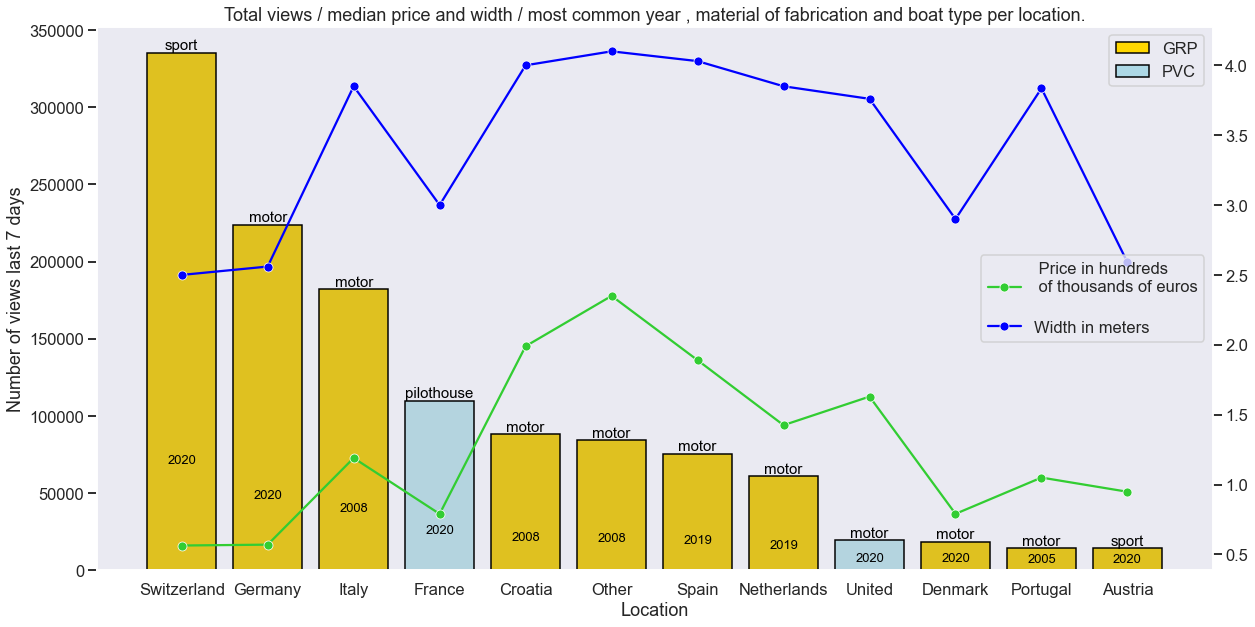

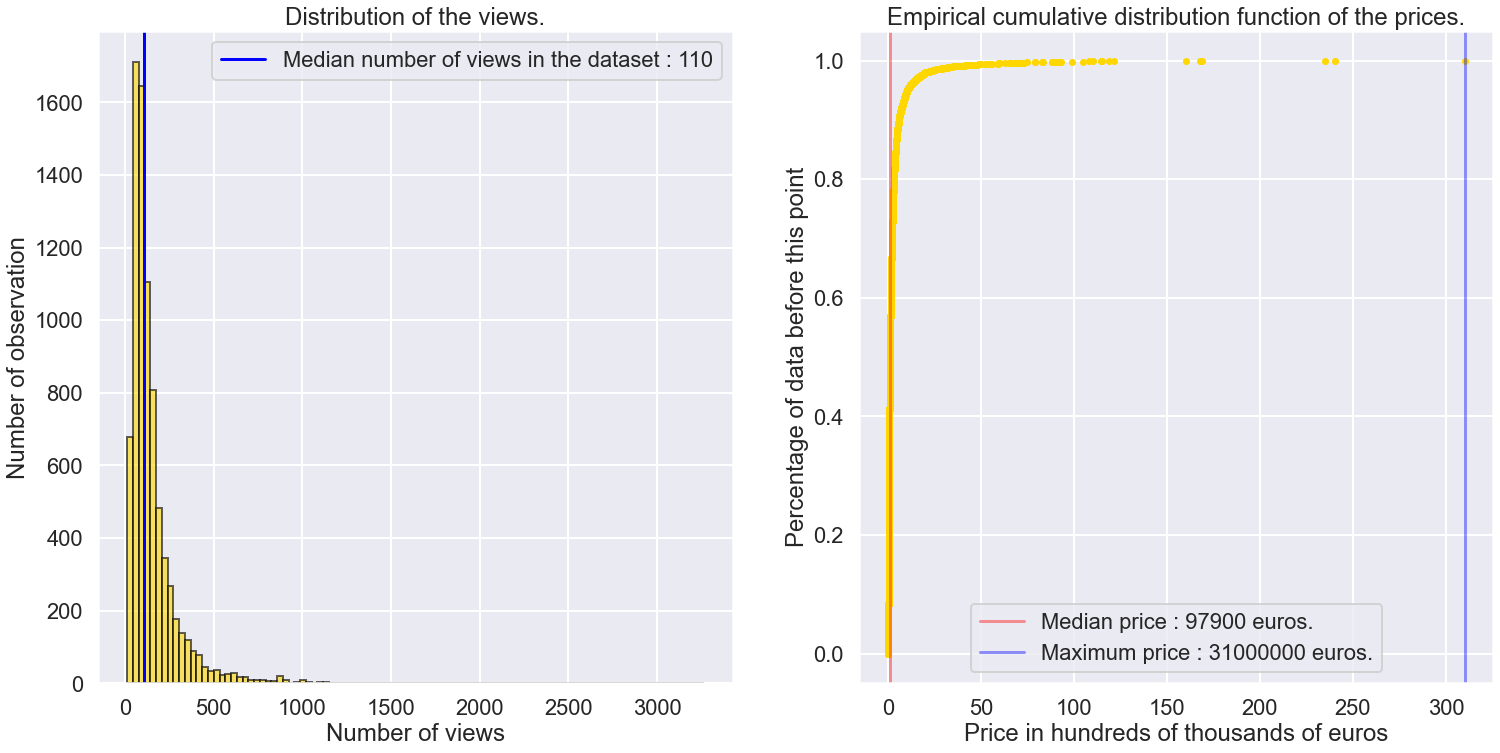

In [5]:
# Create a dataframe grouped by location with the price , number of views , favorite material
to_plot = df.groupby('Location')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days' , ascending=False).nlargest(12 , columns='Number of views last 7 days')

# Change the least represented location to 'Other'
df['Location'] = [loc_ if loc_ in (list(to_plot.index)) else 'Other' for loc_ in df['Location']]

# Actualize the plotting dataframe
to_plot = df.groupby('Location')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days' , ascending=False).nlargest(12 , columns='Number of views last 7 days').join(df.groupby('Location')['Boat Type'].agg(statistics.mode))

# Add the median price and width per location
to_add = df.groupby('Location')[['Price' , 'Width' , 'Year Built']].agg({'Price' : np.median  , 'Width' : np.median , 'Year Built' : statistics.mode})
to_plot[['Price' , 'Width' , 'Year Built']] = to_add[['Price' , 'Width' , 'Year Built']]
to_plot['Price'] = to_plot['Price'] / 100000

# Favorite material per location , for mapping the colors
fav_mat = dict(df[df['Location'].isin(list(to_plot.index))].groupby('Location')['Material'].apply(statistics.mode).apply(lambda x : x.replace('GRP' , 'gold').replace('PVC' , 'lightblue')))

# Style matters
sns.set_style('dark')


# Function to add text in the middle of the bar
def autolabel_center(rects , ax , to_plot): 
    for i in range(len(rects)):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width() / 2, 0.2 * height,to_plot[i]\
             , ha='center', va='bottom', color='black' , fontsize=13)


# Function to add text above the bar
def autolabel_up(rects , ax , to_plot): 
    for i in range(len(rects)):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width() / 2 , height,to_plot[i]\
             , ha='center', va='bottom', color='black' , fontsize=15)


# Function to plot the ECDF
def ecdf(data):
    '''Return the Empirical Cumulative Distribution Function'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1 , n+1) / n 
    return x , y


# Visualisation of the results
with sns.plotting_context('talk'):
    plt.figure(figsize=(20,10))
    ax = sns.barplot(x=to_plot.index , y=to_plot['Number of views last 7 days'] , data=to_plot , color='gold' , edgecolor='black' , palette=fav_mat , label='GRP in gold - PVC in blue')
    autolabel_center(ax.patches , ax , list(to_plot['Year Built'].astype(int)))
    autolabel_up(ax.patches , ax , list(to_plot['Boat Type']))
    pa1 = Patch(facecolor='gold', edgecolor='black')
    pa2 = Patch(facecolor='lightblue', edgecolor='black')
    plt.legend(handles=[pa1 , pa2] , labels=['GRP' , 'PVC']  , loc='upper right')
    ax2 = ax.twinx()
    sns.lineplot(x=to_plot.index , y=to_plot['Price'] , ax=ax2 , color='limegreen' , marker='o' , label=' Price in hundreds\n of thousands of euros\n')
    sns.lineplot(x=to_plot.index , y=to_plot['Width'] , ax=ax2 , color='blue' , marker='o' , label='Width in meters')
    plt.legend(loc='center right')
    plt.ylabel('')
    plt.title('Total views / median price and width / most common year , material of fabrication and boat type per location.')
    plt.show()



# Median number of views
views_median = np.round(df['Number of views last 7 days'].median(),3)

# Ecdf 
x , y = ecdf(df['Price'].values / 100000)

# Median and maximum prices
price_median = np.round(np.median(df['Price'] / 100000),3)
price_max = np.round(np.max(df['Price'] / 100000),3)

# Style matters
sns.set_style('darkgrid')

# Plot the views and prices distributions
with sns.plotting_context('poster'):
    fig , (ax1 , ax2) = plt.subplots(1,2,figsize=(25,12))
    df['Number of views last 7 days'].hist(bins=100 , color='gold'  , alpha=0.6 ,  edgecolor='black' , ax=ax1)
    ax1.axvline(views_median , color='blue' , label=f'Median number of views in the dataset : {int(views_median)}')
    ax1.set_ylabel('Number of observation')
    ax1.set_xlabel('Number of views')
    ax1.legend()
    ax1.title.set_text('Distribution of the views.')
    ax2.plot(x , y , marker='.' , linestyle='none' , color='gold')
    plt.axvline(price_median , alpha=0.4 , color='red' , label=f'Median price : {int(price_median * 100000)} euros.')
    plt.axvline(price_max , alpha=0.4 , color='blue' , label=f'Maximum price : {int(price_max * 100000)} euros.')
    plt.xlabel('Price in hundreds of thousands of euros')
    plt.ylabel('Percentage of data before this point')
    plt.title('Empirical cumulative distribution function of the prices.')
    plt.legend()

## Construction of a machine-learning ready dataframe : 
In order not to increase the dimensionality, which would have made the analysis of variables of importance difficult, I chose to use Target encoding to deal with categorical data.

In [6]:
# Initialize the dataframe , with just the numerical columns
ml_df = df[['Price' , 'Year Built' , 'Length' , 'Width']]


# Create a function to target encode the categorical data
def target_encoding(cat : str , df_ : pd.DataFrame , ml_df=ml_df , target='Number of views last 7 days'):
    '''Target encode a specified column and returns the newly modified dataframe.'''
    encodings = df_.groupby(cat)[target].mean().reset_index()
    ml_df = df_.merge(encodings, how='left', on=cat)
    ml_df.drop(cat , axis=1 , inplace=True , errors='ignore')
    return ml_df


# Target encoding
ml_df = target_encoding(cat='Boat Type' , df_=df)
ml_df = target_encoding(cat='Manufacturer' , df_=ml_df , target='Number of views last 7 days_x')
ml_df = target_encoding(cat='Type' , df_=ml_df , target='Number of views last 7 days_x_x')
ml_df = target_encoding(cat='Material' , df_=ml_df , target='Number of views last 7 days_x_x_x')
ml_df = target_encoding(cat='Location' , df_=ml_df , target='Number of views last 7 days_x_x_x_x')
ml_df.columns = ['Price' , 'Year Built' , 'Length' , 'Width' , 'views' , 'Boat_type' , 'Manufacturer' , 'Type' , 'Material' , 'Location']
ml_df.head(3)

,Price,Year Built,Length,Width,views,Boat_type,Manufacturer,Type,Material,Location
0,3403.74,2017,4.0,1.9,226,136.966696,226.000000,134.407332,162.791452,350.248434
1,3490.00,2020,4.0,1.5,75,100.953704,250.461538,134.407332,256.785714,162.813091
2,3367.00,2020,3.0,1.0,64,188.588936,101.857143,134.407332,501.613333,128.692308


## Model building

Because this dataset is multi-dimensional, and because this model handles non-linearity and outliers very well, I chose to start by creating a random forest model. As a benchmark, I chose an XGboost model, whose effectiveness is well established. The first model turned out to work better, so I focused my efforts around it.

In [7]:
# Split the data
X = ml_df.drop('views' , axis=1)
y = ml_df['views']
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2)

# Initialize models
model_forest = RandomForestRegressor(n_jobs=-1)
model_xgboost = XGBRegressor()

# Fit them to the training data 
model_forest.fit(X_train , y_train)
model_xgboost.fit(X_train , y_train)

# First evaluation 
pred_f = model_forest.predict(X_test)
pred_xg = model_xgboost.predict(X_test)

# Display the results
print('Random forest mean_absolute_percentage_error score : ' , np.round(mean_absolute_percentage_error(y_test , pred_f),3))
print('XGboost mean_absolute_percentage_error score : ' , np.round(mean_absolute_percentage_error(y_test , pred_xg),3))

Random forest mean_absolute_percentage_error score :  0.469
XGboost mean_absolute_percentage_error score :  0.482


## Model optimization : 

I optimized the hyper-parameters of my model using GridSearchCV , in order to try all possible combinations and find the best one. I then used KFold to validate my model using the same metric ; the mean absolute percentage error.

In [8]:
# To save time and because I couldn't load it in my datacamp workspace , I did the optimization in my personnal IDE. This is however the code I used
if 1 + 1 == 3:

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100 , stop = 2000, num = 10)]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt' , 'log2']

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 6]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}


    # search across 100 different combinations, and use all available cores
    best_model = GridSearchCV(estimator = RandomForestRegressor(n_jobs=-1), param_grid = grid,  cv = 5, verbose=0, n_jobs = -1)

    # Fit the random search model
    best_model.fit(X_train, y_train)

    # Predictions of the optimized model
    preds = best_model.predict(X_test)

else:

    # Best hyperparameters after optimization
    best_params = {'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 311}

    # Create the final model and fit him to the training data
    model = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    model.fit(X_train , y_train)

    # Get the prediction to make sure that I really improve the model
    preds = model.predict(X_test)

# Display the results
print('Optimized model mean_absolute_percentage_error : ' , np.round(mean_absolute_percentage_error(y_test , preds), 3))

Optimized model mean_absolute_percentage_error :  0.45


In [9]:
# Cross validate the final model with KFold and display the results
kf = KFold(20 , shuffle=True , random_state=23)
results = cross_val_score(model , X , y , cv=kf , scoring='neg_mean_absolute_percentage_error')
print('Cross valided model results :\n- Negative mean absolute percentage error : ' , np.round(np.mean(results),3) , '\n- Standard deviation : ' , np.round(np.std(results),3))

Cross valided model results :
- Negative mean absolute percentage error :  -0.465 
- Standard deviation :  0.027


## Analysis of predictive variables : 

I used the correlations with the target variable, as well as the features importance distribution of the variables in my model.

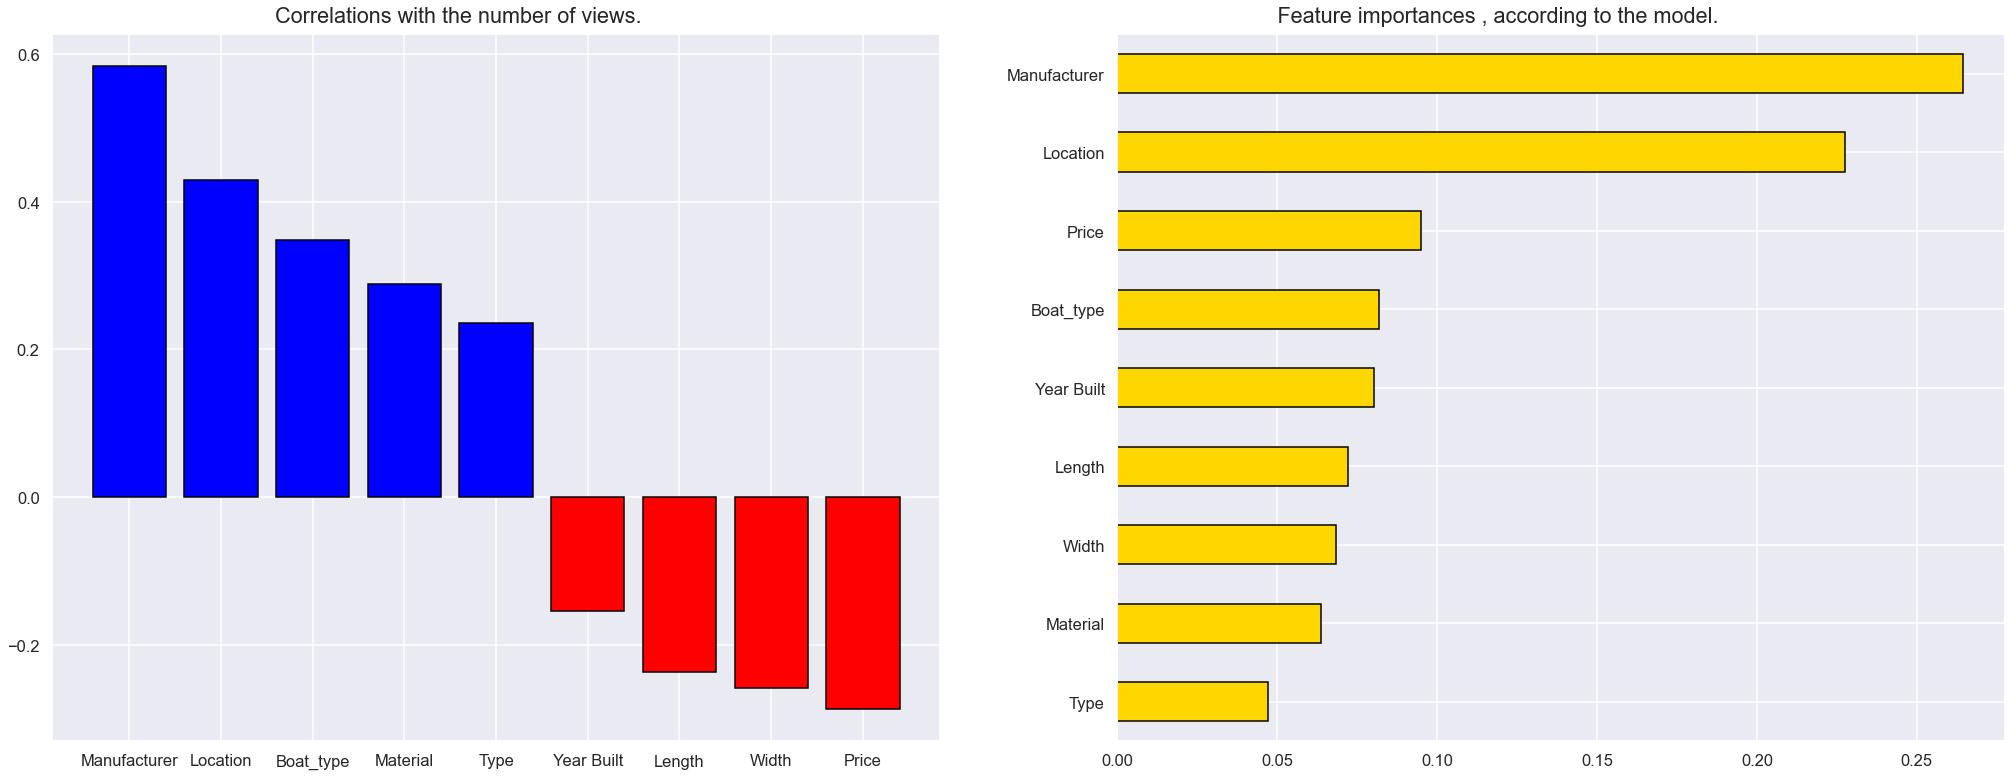

In [10]:
# Create a function to compute the correlation between all the features and the target variable
def check_correlation(target : str , df : pd.DataFrame , method : str):
    """Returns a sorted dataframe with the columns names and their correlation with 
    the specified target variable"""
   
    cor = [df[target].corr(df[col] , method=method) for col in df.columns]
    dictio = dict(zip(df.columns , cor))
    return pd.DataFrame({'columns' : dictio.keys()  , 'correlation_with_the_specified_target' : dictio.values()})\
    .sort_values(by=['correlation_with_the_specified_target'] , ascending=False)[1:]
    
# Fit the final model to get the features importances
model.fit(X_train , y_train)

# Get the correlation dataframe
corr = check_correlation('views' , ml_df , 'spearman')

# To map the colors
color = ['blue' if corr_ >= 0 else 'red' for corr_ in corr['correlation_with_the_specified_target']]

# Plot the features of importance according to the model , and the spearman coefficient of correlation 
with sns.plotting_context('talk'):
    sns.set_style('darkgrid')
    fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(35,13))
    ax1.bar(corr['columns'] , corr['correlation_with_the_specified_target'] , edgecolor='black' , color=color)
    pd.Series(model.feature_importances_ , index=ml_df.drop(['views'] , axis=1).columns).sort_values(ascending=True).plot(kind='barh' , color='gold' , edgecolor='black')
    fig.suptitle('Correlations with the number of views.                                                                                                          Feature importances , according to the model.' , y=0.91)
    plt.show()